TODOs

* use a proper mask. it should be tighter than the current one
* fill outside mask

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

N = 64

def get_squared_distance():
    """
    Return array of distances from the center
    """
    centered_indices = np.arange(N) - N // 2 + .5
    x, y = np.meshgrid(centered_indices, centered_indices)
    d = np.sqrt(x*x+y*y)
    return d

#obj = np.load('/Users/ollie/Downloads/data_recon.npz')
obj = np.load('recon_2x2_1x1_with_positions.npz')

import ptycho.tf_helper as hh

imgs, coords = obj['imgs'], obj['coords']

mask = hh.mk_centermask(imgs, N, 4, kind = 'center')
imgs = np.array(imgs * mask)
# imgs = imgs[:, 16:-16, 16:-16, :]
# imgs = imgs / imgs.mean()

from ptycho import probe
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = obj#np.load('/mnt/data/data (1).npz')
# imgs = torch.tensor(data['imgs'])
imgs = torch.tensor((imgs))
mask = torch.tensor(np.array(mask))

# # use tighter mask
# imgs = torch.tensor((imgs))
# mask = torch.tensor(np.array(mask))
probe_mask_real = (get_squared_distance() < N // 4)[..., None]
mask[...] = torch.tensor(probe_mask_real)
imgs = imgs * mask



def torch_cross_image_full(im1, im2, submean = False,
                          return_complex = False, convolve = False):
    # convolution instead of cross correlation
    # Subtract the mean
    if submean:
        im1_gray = im1 - torch.mean(im1, axis = [1, 2])[:, None, None]
        im2_gray = im2 - torch.mean(im2, axis = [1, 2])[:, None, None]
    else:
        im1_gray = im1 #- torch.mean(im1, axis = [1, 2])[:, None, None]
        im2_gray = im2 #- torch.mean(im2, axis = [1, 2])[:, None, None]
    
    # Zero-pad both images to double the size
    N = im1_gray.shape[-1] // 2
    im1_padded = torch.nn.functional.pad(im1_gray, (0, N, 0, N))
    im2_padded = torch.nn.functional.pad(im2_gray, (0, N, 0, N))
    
    # Compute FFT for both padded images
    fft_im1 = torch.fft.fft2(im1_padded)
    fft_im2 = torch.fft.fft2(im2_padded)
    
    # Multiply FFT of im1 with the complex conjugate of the FFT of reversed im2
#     product = fft_im1 * torch.conj(fft_im2.flip([-2, -1]))
    if convolve:
        product = fft_im1 * fft_im2
    else:
        product = fft_im1 * torch.conj(fft_im2)
    
    # Compute inverse FFT to get the cross-correlation
    cross_corr_complex = torch.fft.fftshift(torch.fft.ifft2(product))
    
    # Extract real component
    cross_corr_magnitude = torch.abs(cross_corr_complex)
    norm = torch.max(cross_corr_magnitude)
    
    if return_complex:
        return cross_corr_complex / norm
    
    return cross_corr_magnitude / norm

2023-10-26 20:07:08.387288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 20:07:08.479196: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-26 20:07:08.889830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ollie/anaconda3/envs/tf/lib/
2023-10-26 20:07:08.889875: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [2]:
np.savez('poscorrection_selfcontained.npz', imgs = imgs[:5], mask = mask[:5], coords = coords[:5])

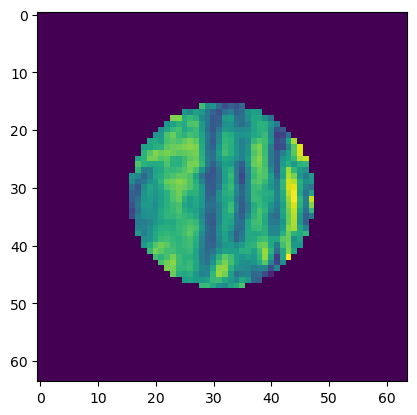

In [3]:
plt.imshow(np.abs(imgs[0, :, :, 0]))

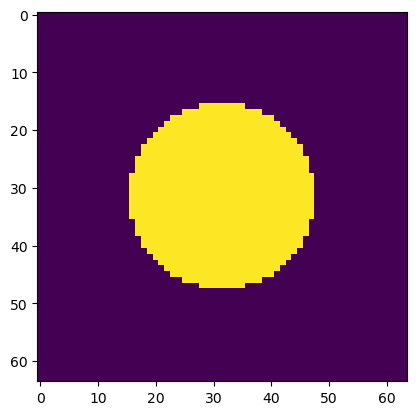

In [4]:
plt.imshow(np.abs(mask[0, :, :, 0]))

In [5]:
# import torch
# import numpy as np

# def nearest_neighbor_infill(tensor):
#     """
#     Perform nearest neighbor infill on a 4D tensor.
    
#     Parameters:
#         tensor (torch.Tensor): A 4D tensor with dimensions [batch_size, height, width, channels]
        
#     Returns:
#         torch.Tensor: A tensor with zero regions infilled using nearest-neighbor algorithm
#     """
    
#     # Create a mask for zero regions
#     zero_mask = torch.abs(tensor) == 0
    
#     # Iterate through batch and channel dimensions
#     for i in range(tensor.shape[0]):
#         for j in range(tensor.shape[3]):
            
#             # Extract the 2D slice
#             slice_2d = tensor[i, :, :, j]
#             zero_mask_2d = zero_mask[i, :, :, j]
            
#             # Find the non-zero elements and their indices
#             non_zero_indices = torch.nonzero(~zero_mask_2d)
#             non_zero_values = slice_2d[~zero_mask_2d]
            
#             # Find the zero elements and their indices
#             zero_indices = torch.nonzero(zero_mask_2d)
            
#             # Use nearest-neighbor infilling
#             for zero_index in zero_indices:
#                 distances = torch.sum((non_zero_indices - zero_index)**2, dim=1)
#                 nearest_index = torch.argmin(distances)
#                 slice_2d[tuple(zero_index)] = non_zero_values[nearest_index]
            
#             # Update the original tensor
#             tensor[i, :, :, j] = slice_2d
    
#     return tensor

# # Usage
# # Assuming 'imgs_tensor' is your original tensor
# # infilled_tensor = nearest_neighbor_infill(imgs_tensor)
# tmp = nearest_neighbor_infill(imgs)

In [12]:
epsilon = .1
nn = 16#54
# ccorr_ref = torch_cross_image_full(imgs[:, :, :, 0], imgs[:, :, :, 0], convolve=False, submean = True)[:, nn: -nn, nn: -nn]


def channel_ccorr(imgs, i):
    ccorr = torch_cross_image_full(imgs[:, :, :, 0], imgs[:, :, :, i])[:,  nn: -nn, nn: -nn]
    ncorr = torch_cross_image_full(torch.abs(mask[:, :, :, 0]), torch.abs(mask[:, :, :, i]))[:, nn: -nn, nn: -nn]
    return (ccorr / (epsilon + np.abs(ncorr)))

gridsize = 2
ccorr2s = torch.stack(tuple(channel_ccorr(imgs, i) for i in range(gridsize**2)), dim=-1)

In [13]:
# ccorr2s[:, :mm, :, :] = 0
# ccorr2s[:, -mm:, :, :] = 0
# ccorr2s[:, :, :mm, :] = 0
# ccorr2s[:, :, -mm:, :] = 0

# TODO get weighted center of mass instead of center of mass of binary mask
# New function definition
def find_peak_positions(tensor, nominal_coords):
    b, N, _, c = tensor.shape
    result = torch.zeros((b, 1, 2, c), dtype=tensor.dtype)
    reshaped_tensor = tensor.view(b, N * N, c)
    max_val, _ = torch.max(reshaped_tensor, dim=1, keepdim=True)
    mask = (reshaped_tensor >= max_val * 0.9)
    x, y = torch.meshgrid(torch.arange(N), torch.arange(N))
    x = x.flatten().float()
    y = y.flatten().float()
    
    for i in range(c):
        channel_mask = mask[:, :, i]
        mass_x = torch.sum(x * channel_mask.float(), dim=1) / torch.sum(channel_mask, dim=1)
        mass_y = torch.sum(y * channel_mask.float(), dim=1) / torch.sum(channel_mask, dim=1)
        
        # cross correlation offsets are sign-flipped relative to the model's definition
        # Also, for the LCLS data we have to swap x and y
        result[:, 0, 0, i] = -mass_y
        result[:, 0, 1, i] = -mass_x
    
    # Shift so that the first-image relative coords are the same as their nominal coords under the model's
    # definition, which uses the solution region CM as origin
    result = result + N // 2 #+ nominal_coords[:1, ...]
    return result, mask

peak_positions, peakmasks = find_peak_positions(ccorr2s, coords)

# Show the shape and some content of the resulting tensor
peak_positions.shape, peak_positions[:1, :, :, :], coords[:1, ...]

(torch.Size([25, 1, 2, 4]),
 tensor([[[[ 0.0000,  0.9367, -0.7213, -0.4030],
           [ 0.0000, -4.6962, -1.9180, -3.2985]]]]),
 array([[[[ 1.62183805, -0.64688545, -0.26744538, -0.70750723],
          [ 0.0848721 , -1.14667661, -0.34404734,  1.40585185]]]]))

In [14]:
def cmshift(peak_positions):
    return peak_positions - peak_positions.mean(axis = 3)[:, :, :, None]

In [15]:
from scipy.stats import pearsonr

In [23]:
ii = 1
pearsonr((peak_positions - peak_positions[:, :, :, :1])[:, :, ii, :].ravel(),
         (coords - coords[:, :, :, :1])[:, :, ii, :].ravel())

(0.2815182079099, 0.004548079539112146)

In [17]:
pearsonr(cmshift(peak_positions)[:, :, ii, :].ravel(),
         cmshift(coords - coords[:, :, :, :1])[:, :, ii, :].ravel())

(0.19180727891562988, 0.05590845303717299)

In [24]:
peak_positions.shape

torch.Size([25, 1, 2, 4])

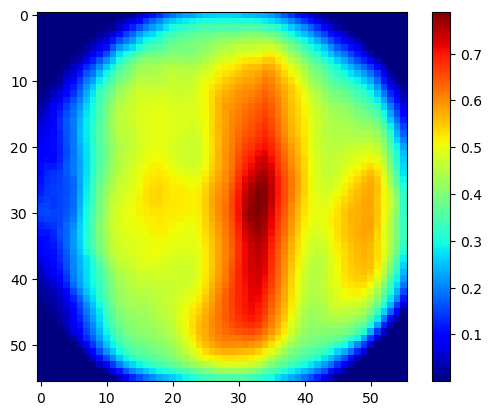

In [18]:
mm = 4
plt.imshow(ccorr2s[24, mm: -mm, mm: -mm, 3], cmap = 'jet')
plt.colorbar()

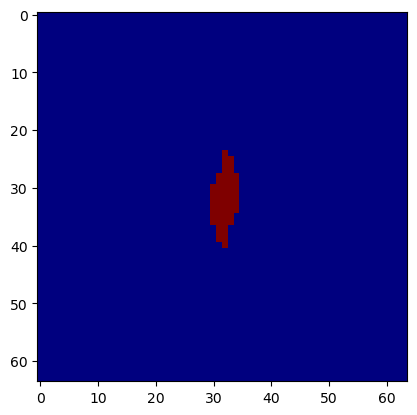

In [19]:
plt.imshow(ccorr2s[0, :, :, 0] >= (0.9 * ccorr2s[0, :, :, 0].max()), cmap = 'jet')


In [96]:
np.std((coords - coords[..., :1])[:, :, 0, :].ravel()), np.std((coords - coords[..., :1])[:, :, 1, :].ravel())

(1.4391395934717246, 1.4003763238713578)

In [93]:
np.std(np.array(peak_positions[:, :, 0, :].ravel())),np.std(np.array(peak_positions[:, :, 1, :].ravel()))

(2.6057518, 1.5918528)

In [20]:
np.std(peak_positions[:, :, 0, :].ravel()), np.std(peak_positions[:, :, 1, :].ravel())

TypeError: std() received an invalid combination of arguments - got (ddof=int, dtype=NoneType, out=NoneType, axis=NoneType, ), but expected one of:
 * (tuple of ints dim, bool unbiased, bool keepdim)
 * (tuple of ints dim, *, int correction, bool keepdim)
      didn't match because some of the keywords were incorrect: ddof, dtype, out, axis
 * (bool unbiased)
 * (tuple of names dim, bool unbiased, bool keepdim)
 * (tuple of names dim, *, int correction, bool keepdim)
      didn't match because some of the keywords were incorrect: ddof, dtype, out, axis


In [268]:
coords[0]

array([[[ 1.62183805, -0.64688545, -0.26744538, -0.70750723],
        [ 0.0848721 , -1.14667661, -0.34404734,  1.40585185]]])

In [98]:
from scipy.ndimage.measurements import center_of_mass as cm